Graph Constrained Unmixing w/ Normalized Cuts

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from SuperpixelCutsPy import *
# Configs for Notebooks
plt.rcParams["figure.figsize"] = [9,7]
np.set_printoptions(suppress=True)

In [2]:
dataset_name = 'fields_data_2022'
h5_import = h5py.File("data/bhsi_2023.h5",'r+').get('Cube/resultarray/inputdata')
hyperspectral_cube = np.array(h5_import)
hyperspectral_cube = np.moveaxis(np.array(hyperspectral_cube), [0], [2])
hyperspectral_cube = np.moveaxis(np.array(hyperspectral_cube), [0], [1])
hyperspectral_cube = hyperspectral_cube[5:205, 5:205, :].copy()
nx,ny,nb = hyperspectral_cube.shape
del h5_import

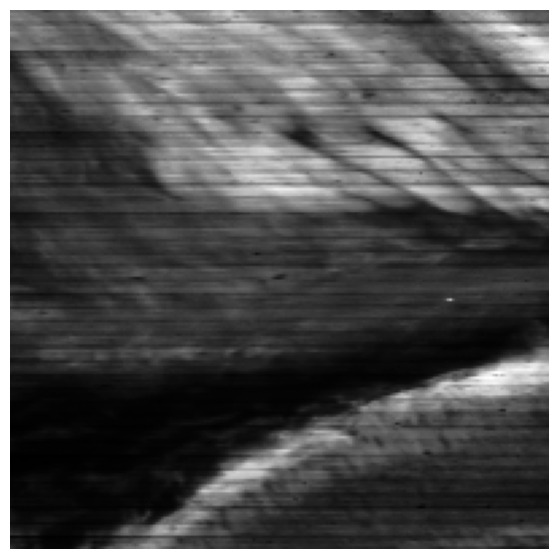

In [3]:
plt.imshow(hyperspectral_cube[:,:,0], cmap = 'Greys_r');
plt.axis('off');

In [4]:
preprocessing_pipeline = Preprocesser.Preprocesser(data = hyperspectral_cube)
#preprocessing_pipeline.gaussian_blur(blur_param = 0)
preprocessing_pipeline.singular_value_decomposition(n_svd = 5)
preprocessing_pipeline.layer_normalization()
hyperspectral_cube = preprocessing_pipeline.data.copy()
original_hyperspectral_cube = preprocessing_pipeline.original_data.copy()

In [5]:
n_superpixels = 2500 #2500
slic_m_param = 3    #2
assignments, centers = superpixel.generate_SLIC_assignments(data = hyperspectral_cube,
                                                            n_superpixels = n_superpixels,
                                                            slic_m_param = slic_m_param)
superpixeled_cube, superpixel_library = superpixel.generate_SLIC_superpixels(data = hyperspectral_cube,
                                                                             assignments = assignments)
n_superpixels = len(np.unique(assignments))

Created 2500 superpixels


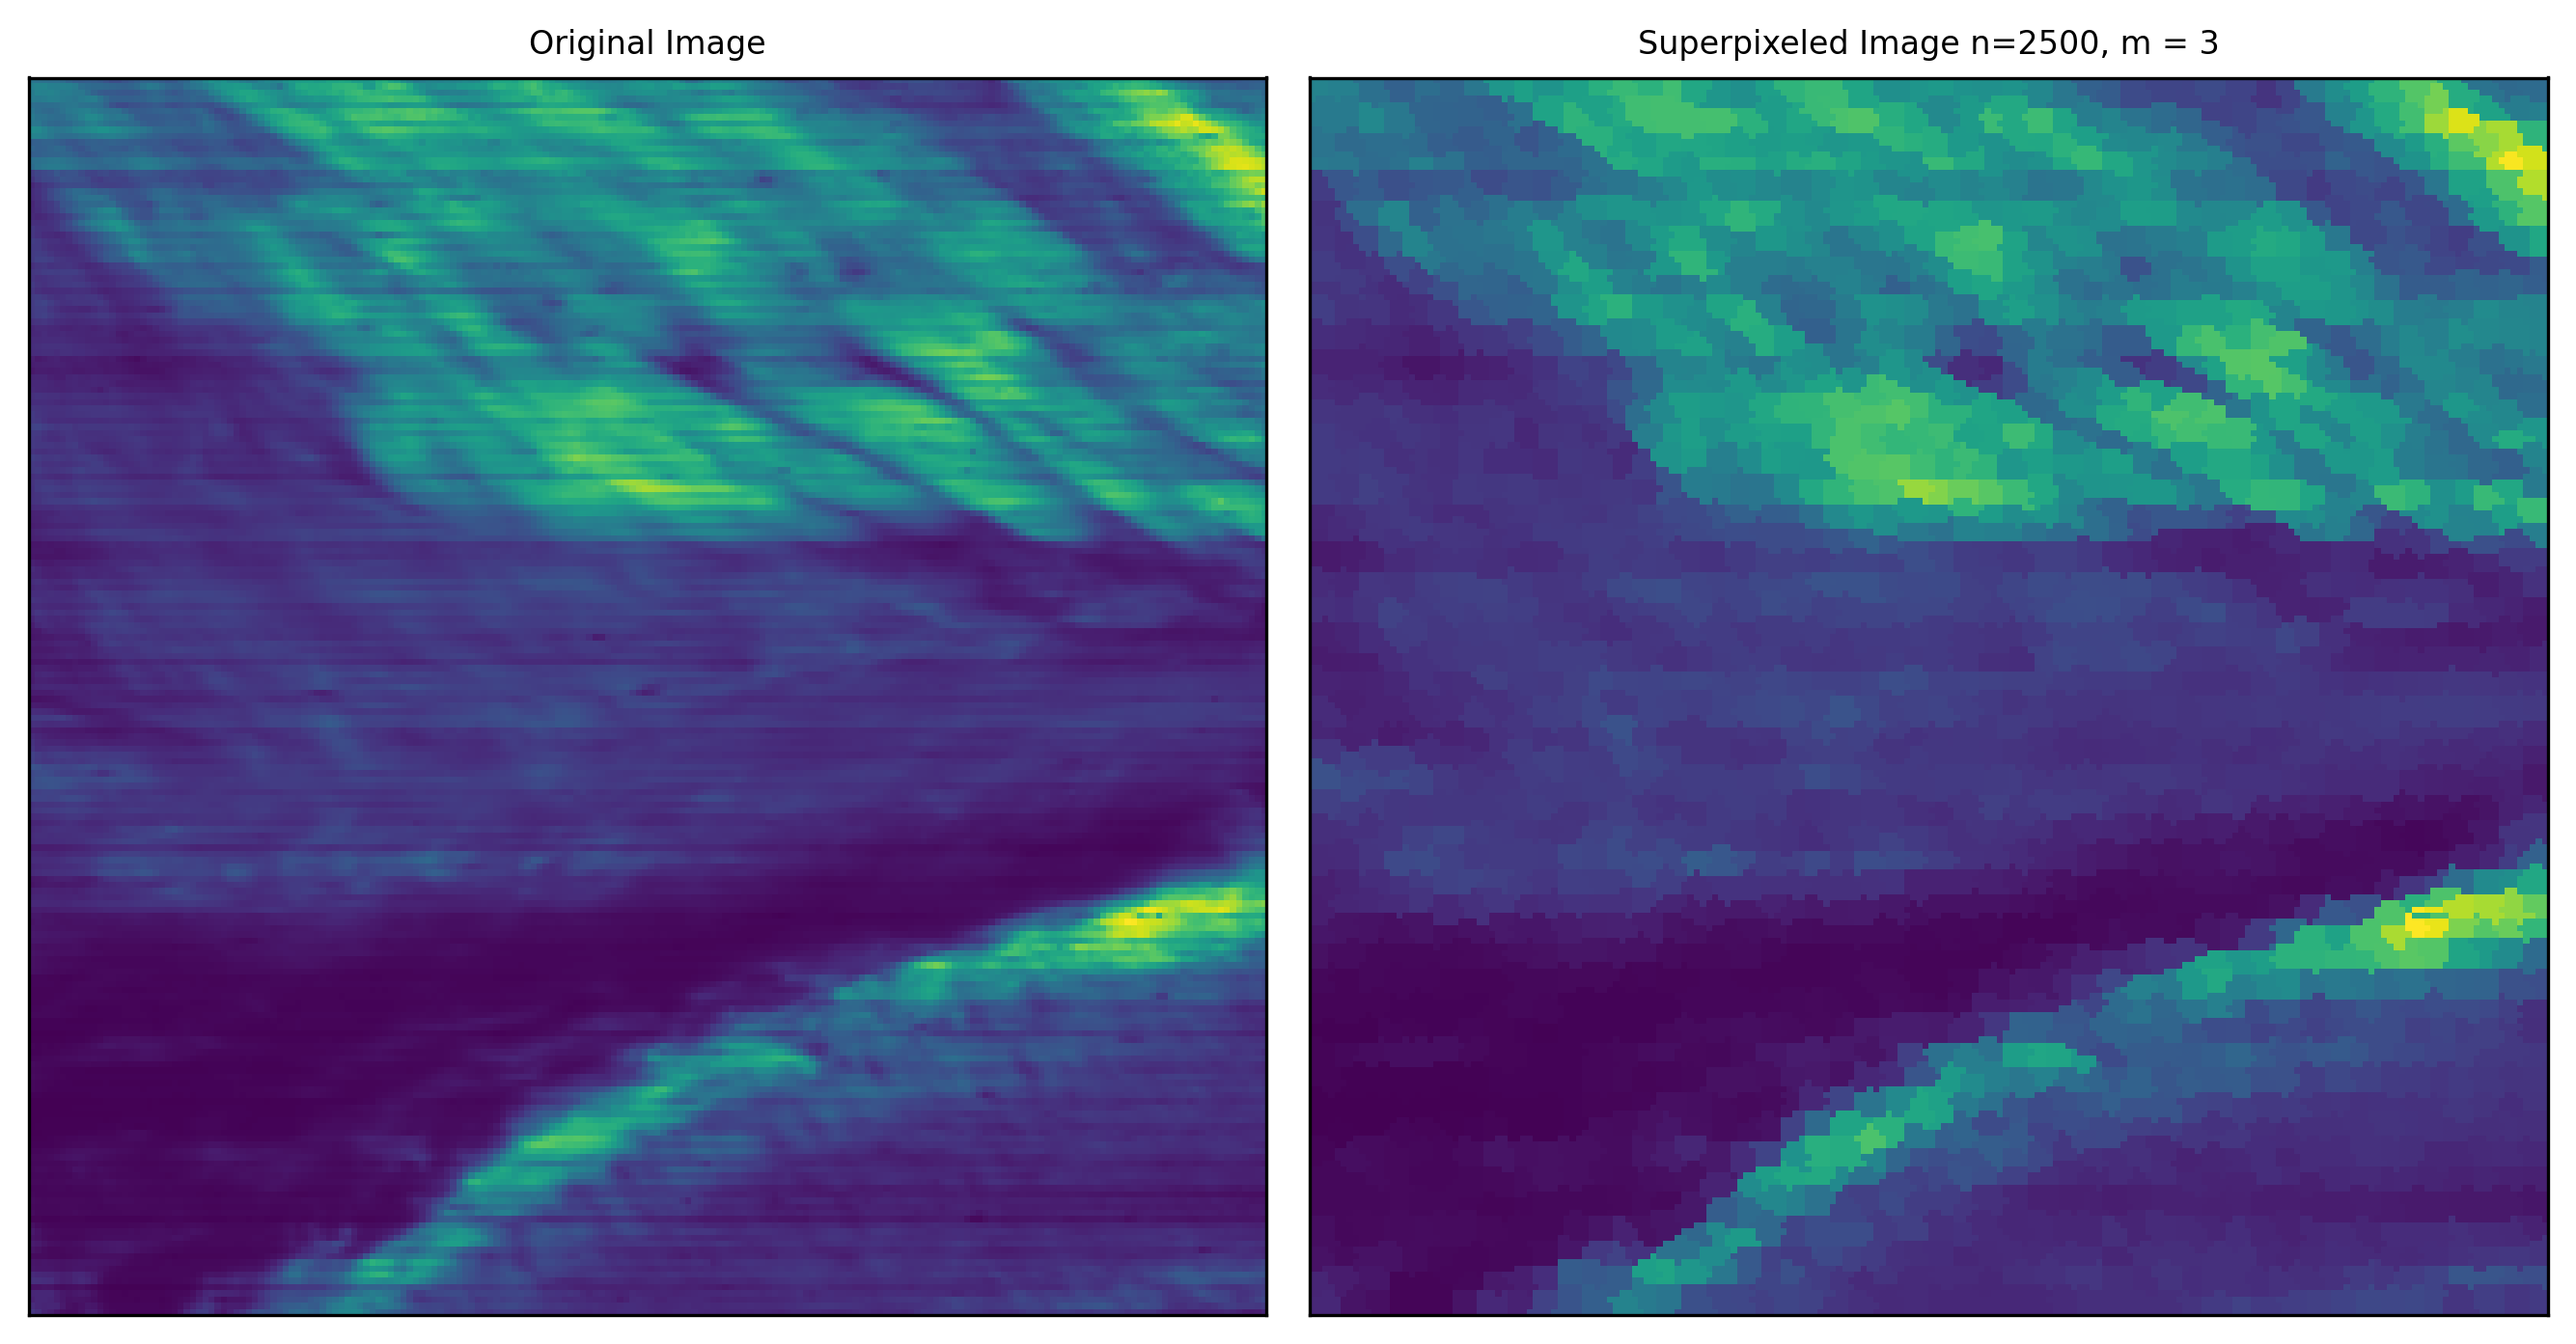

In [6]:
fig, ax = plt.subplots(1,2, dpi=300);
layer_preview = 20
ax[0].imshow(hyperspectral_cube[:,:,layer_preview]);
ax[1].imshow(superpixeled_cube[:,:,layer_preview])
ax[1].scatter(centers[:,1], centers[:,0], c='red', s=0.05, marker = "," );
ax[0].set_title(f'Original Image', fontsize = 8);
ax[1].set_title(f'Superpixeled Image n={n_superpixels}, m = {slic_m_param}', fontsize = 8);
ax[0].set_xticks([]);
ax[0].set_yticks([]);
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.tight_layout();

In [7]:
sigma_param = 0.0025
spatial_limit = 30
spatial_beta_param = 0.025
spatial_dmax_param = 10 #10
ne = 5

labelled_img, normalized_signatures, int_results = normalized_cuts.graph_regularized_ncuts_admm(data=hyperspectral_cube,
                                                                                                superpixel_library=superpixel_library,
                                                                                                superpixel_centers=centers,
                                                                                                superpixel_assignments=assignments,
                                                                                                n_endmembers = ne,
                                                                                                spectral_sigma2_param= sigma_param,
                                                                                                spatial_kappa_param=spatial_limit,
                                                                                                spatial_beta_param= spatial_beta_param,
                                                                                                spatial_dmax_param = spatial_dmax_param,
                                                                                                unmixing_mu_param = 1,
                                                                                                n_unmixing_iters = 200,
                                                                                                spectral_metric='SAM')

original_library  = segmentation_evaluation.calc_mean_label_signatures(utility.cube_to_matrix(original_hyperspectral_cube),
                                                                        labelled_img.reshape(-1))

#original_library = segmentation_evaluation.calc_mean_label_signatures(superpixel_original_library, superpixel_cluster_labels)

Initial Clustering
Spectral + Unmixing Clustering


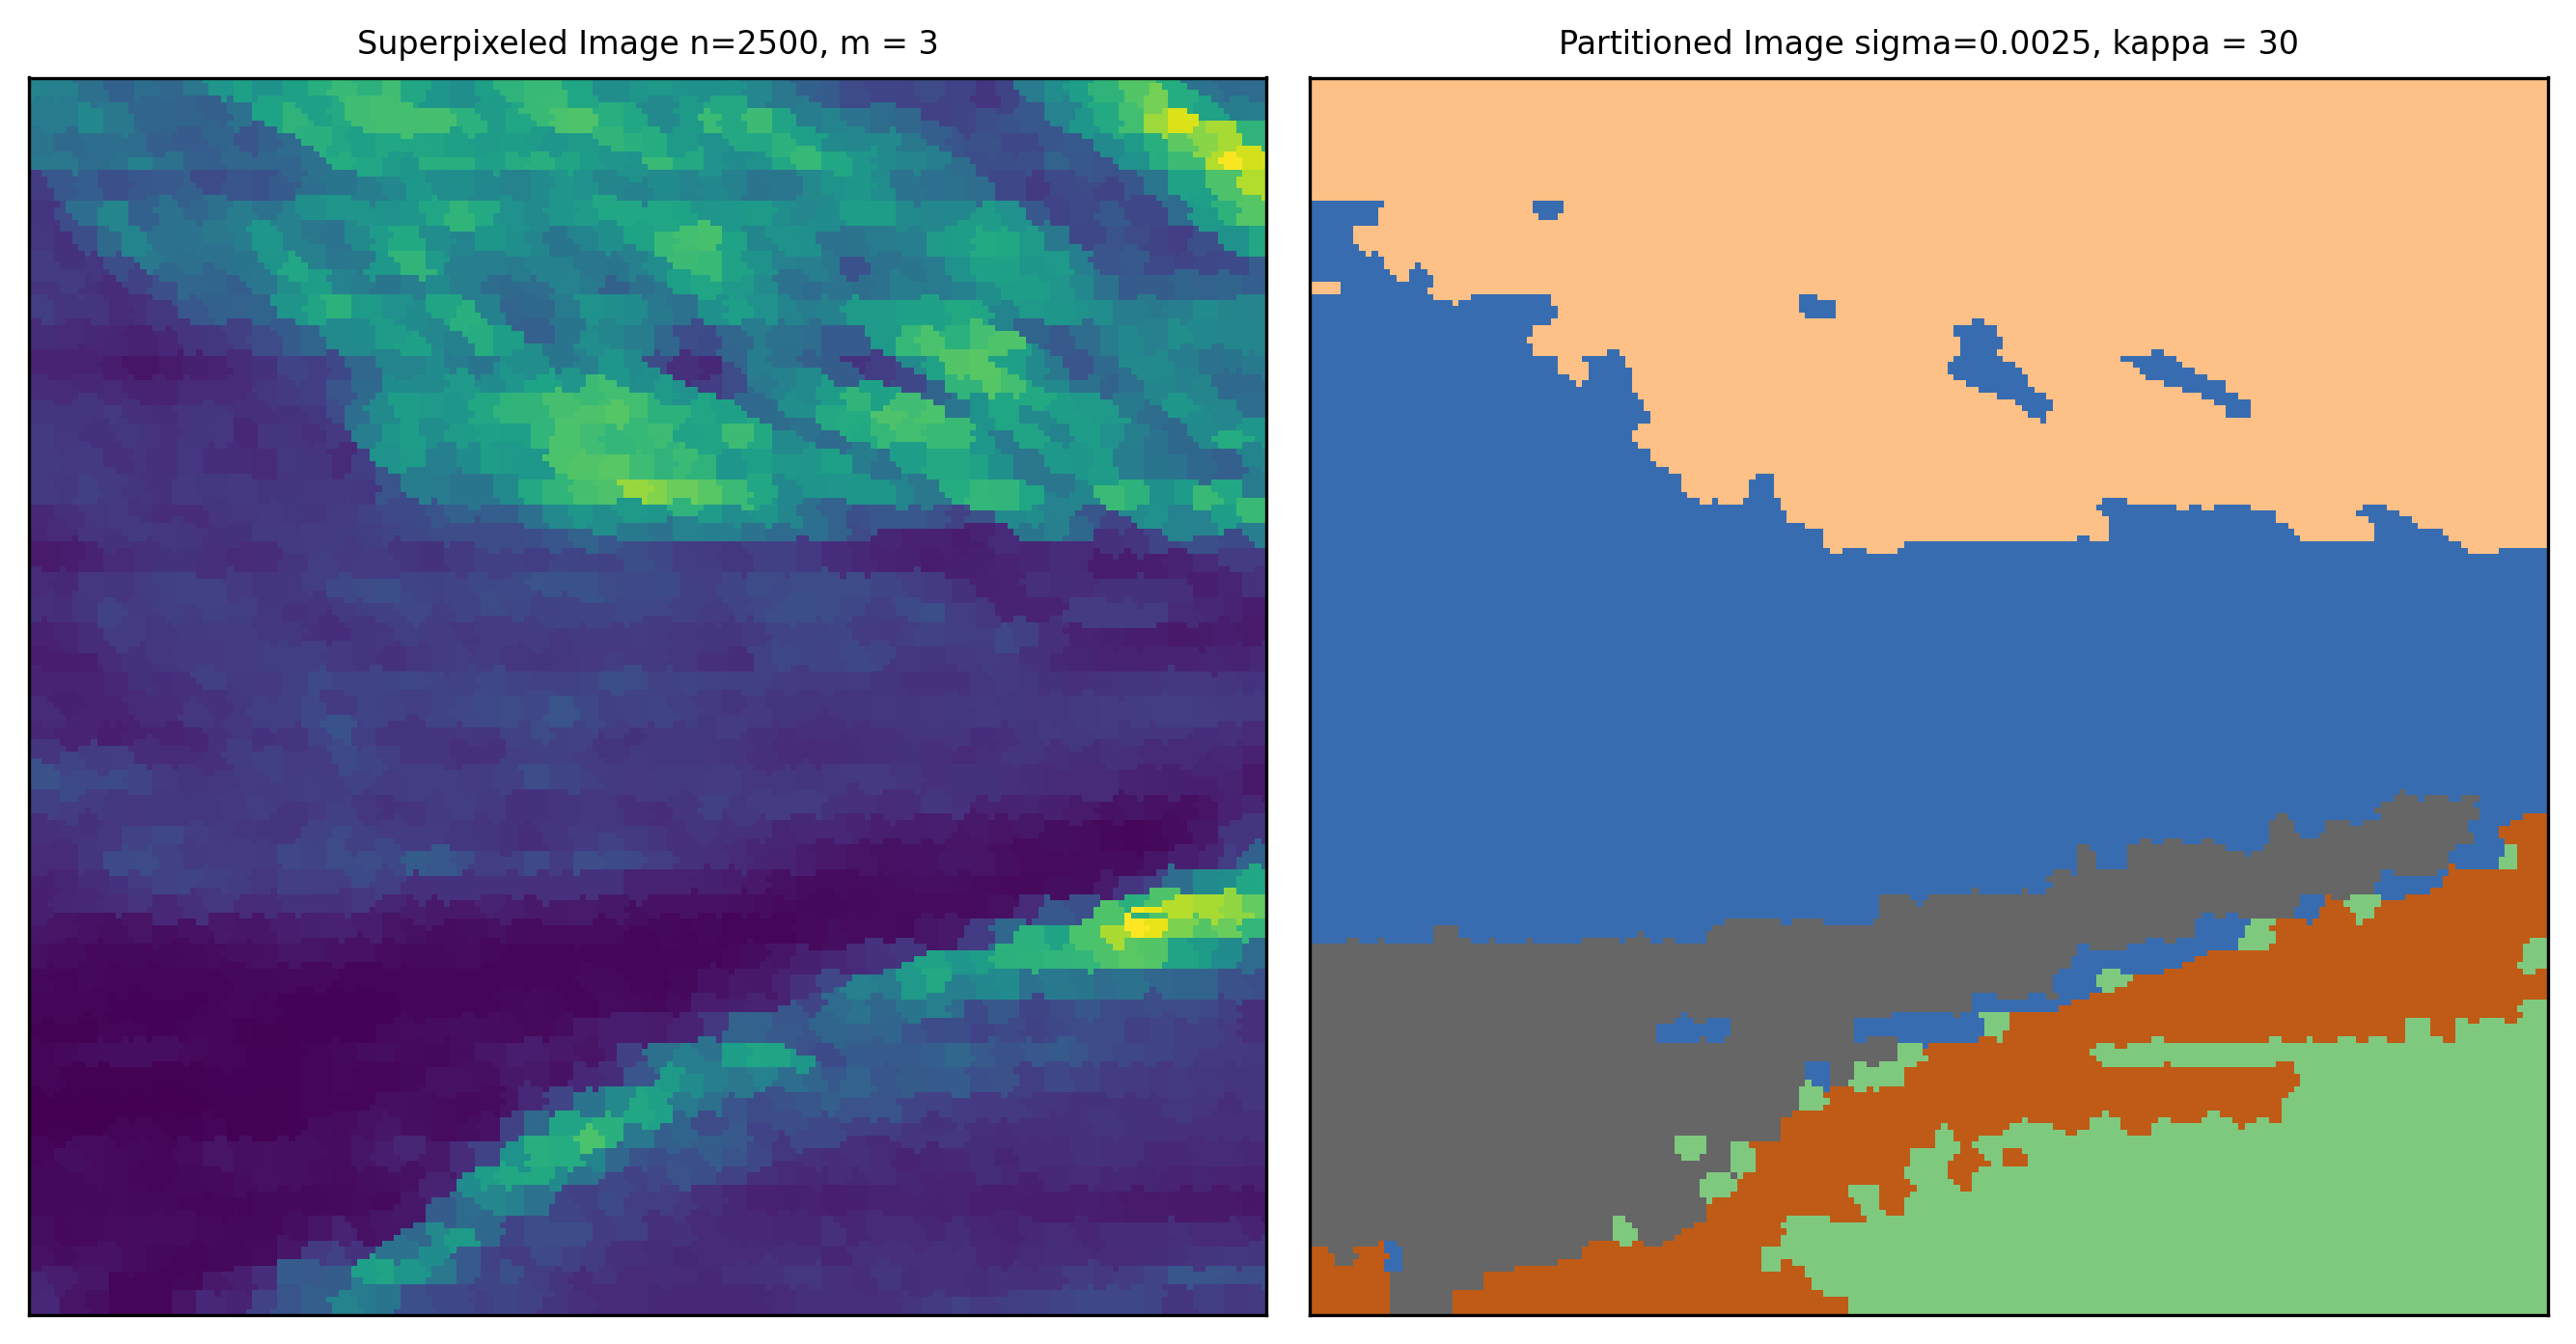

In [17]:
fig, ax = plt.subplots(1,2, dpi=300);
layer_preview = 20
ax[0].imshow(superpixeled_cube[:,:,layer_preview]);
ax[1].imshow(int_results['initial_labels'], cmap = 'Accent')
# ax[1].scatter(centers[:,1], centers[:,0], c='red', s=0.05, marker = "," );
ax[0].set_title(f'Superpixeled Image n={n_superpixels}, m = {slic_m_param}', fontsize = 8);
ax[1].set_title(f'Partitioned Image sigma={sigma_param}, kappa = {spatial_limit}', fontsize = 8);
ax[0].set_xticks([]);
ax[0].set_yticks([]);
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.tight_layout();

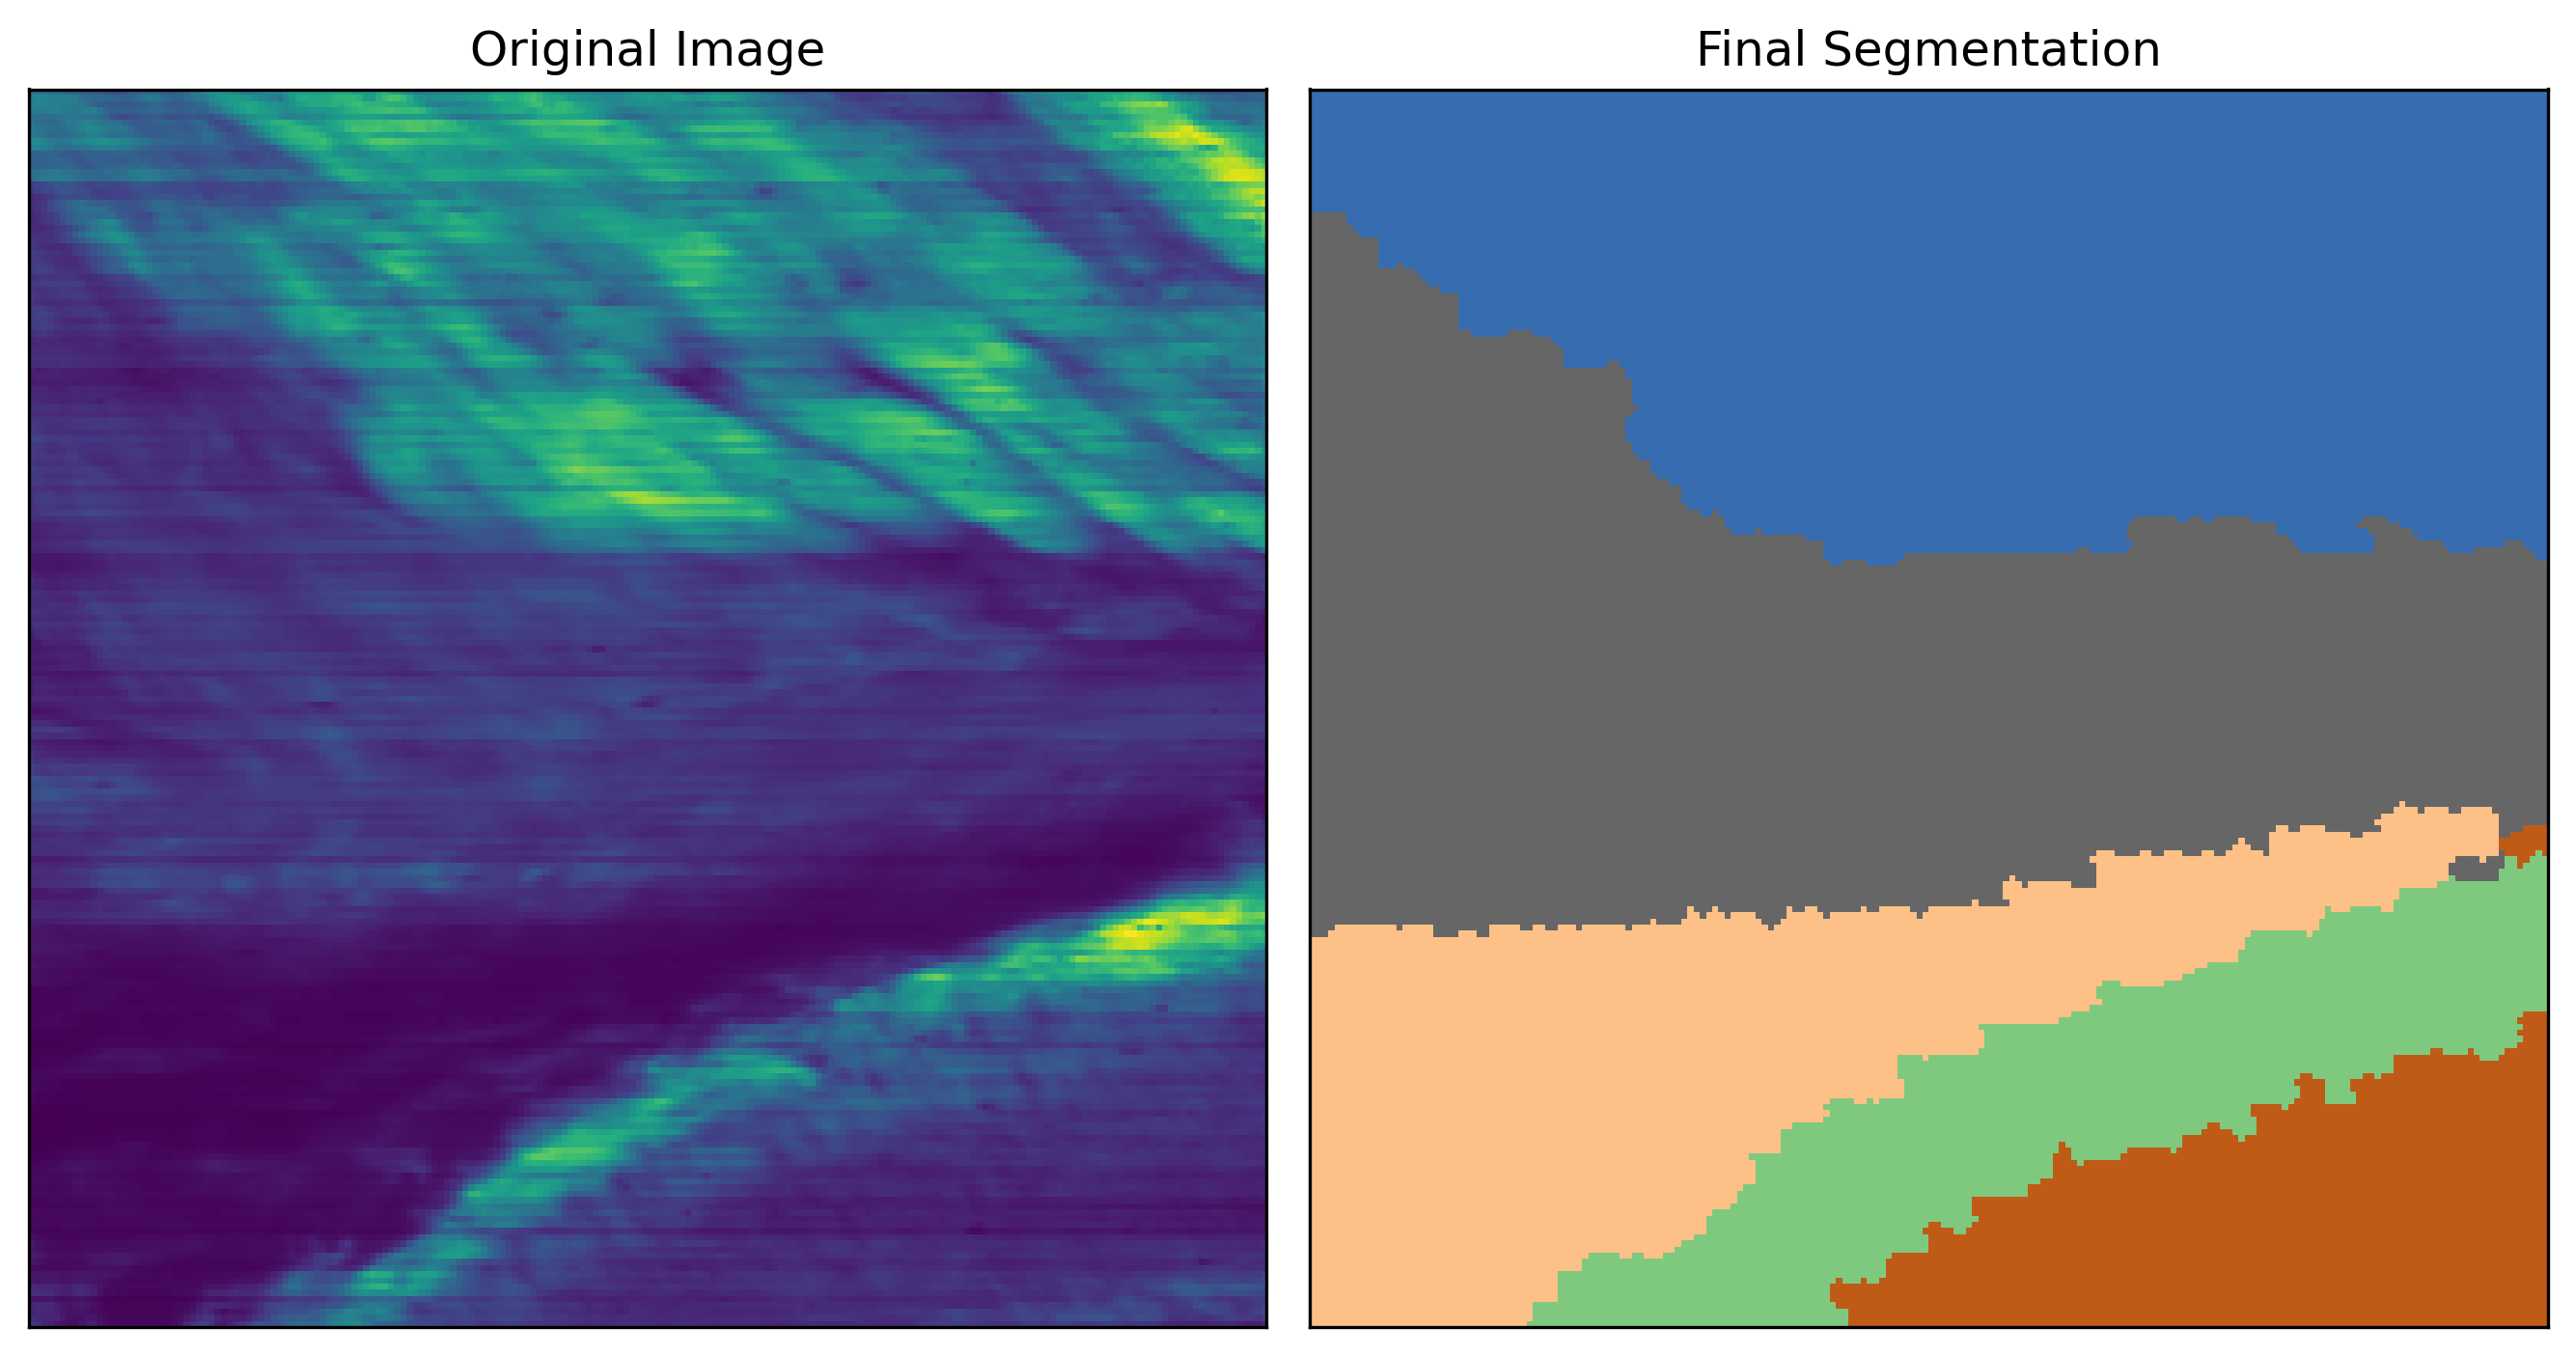

In [18]:
fig, ax = plt.subplots(1,2, dpi=300);
ax[0].imshow(hyperspectral_cube[:,:,layer_preview]);
# ax[1].imshow(int_results['initial_labels'], cmap = 'Accent');
ax[1].imshow(labelled_img, cmap = 'Accent');

ax[0].set_title("Original Image");
# ax[1].set_title("Initial Segmentation");
ax[1].set_title("Final Segmentation");

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
# ax[2].set_xticks([])
# ax[2].set_yticks([])

plt.tight_layout();

C:\Users\apopo\AppData\Local\Temp\ipykernel_26276\192024514.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Accent');


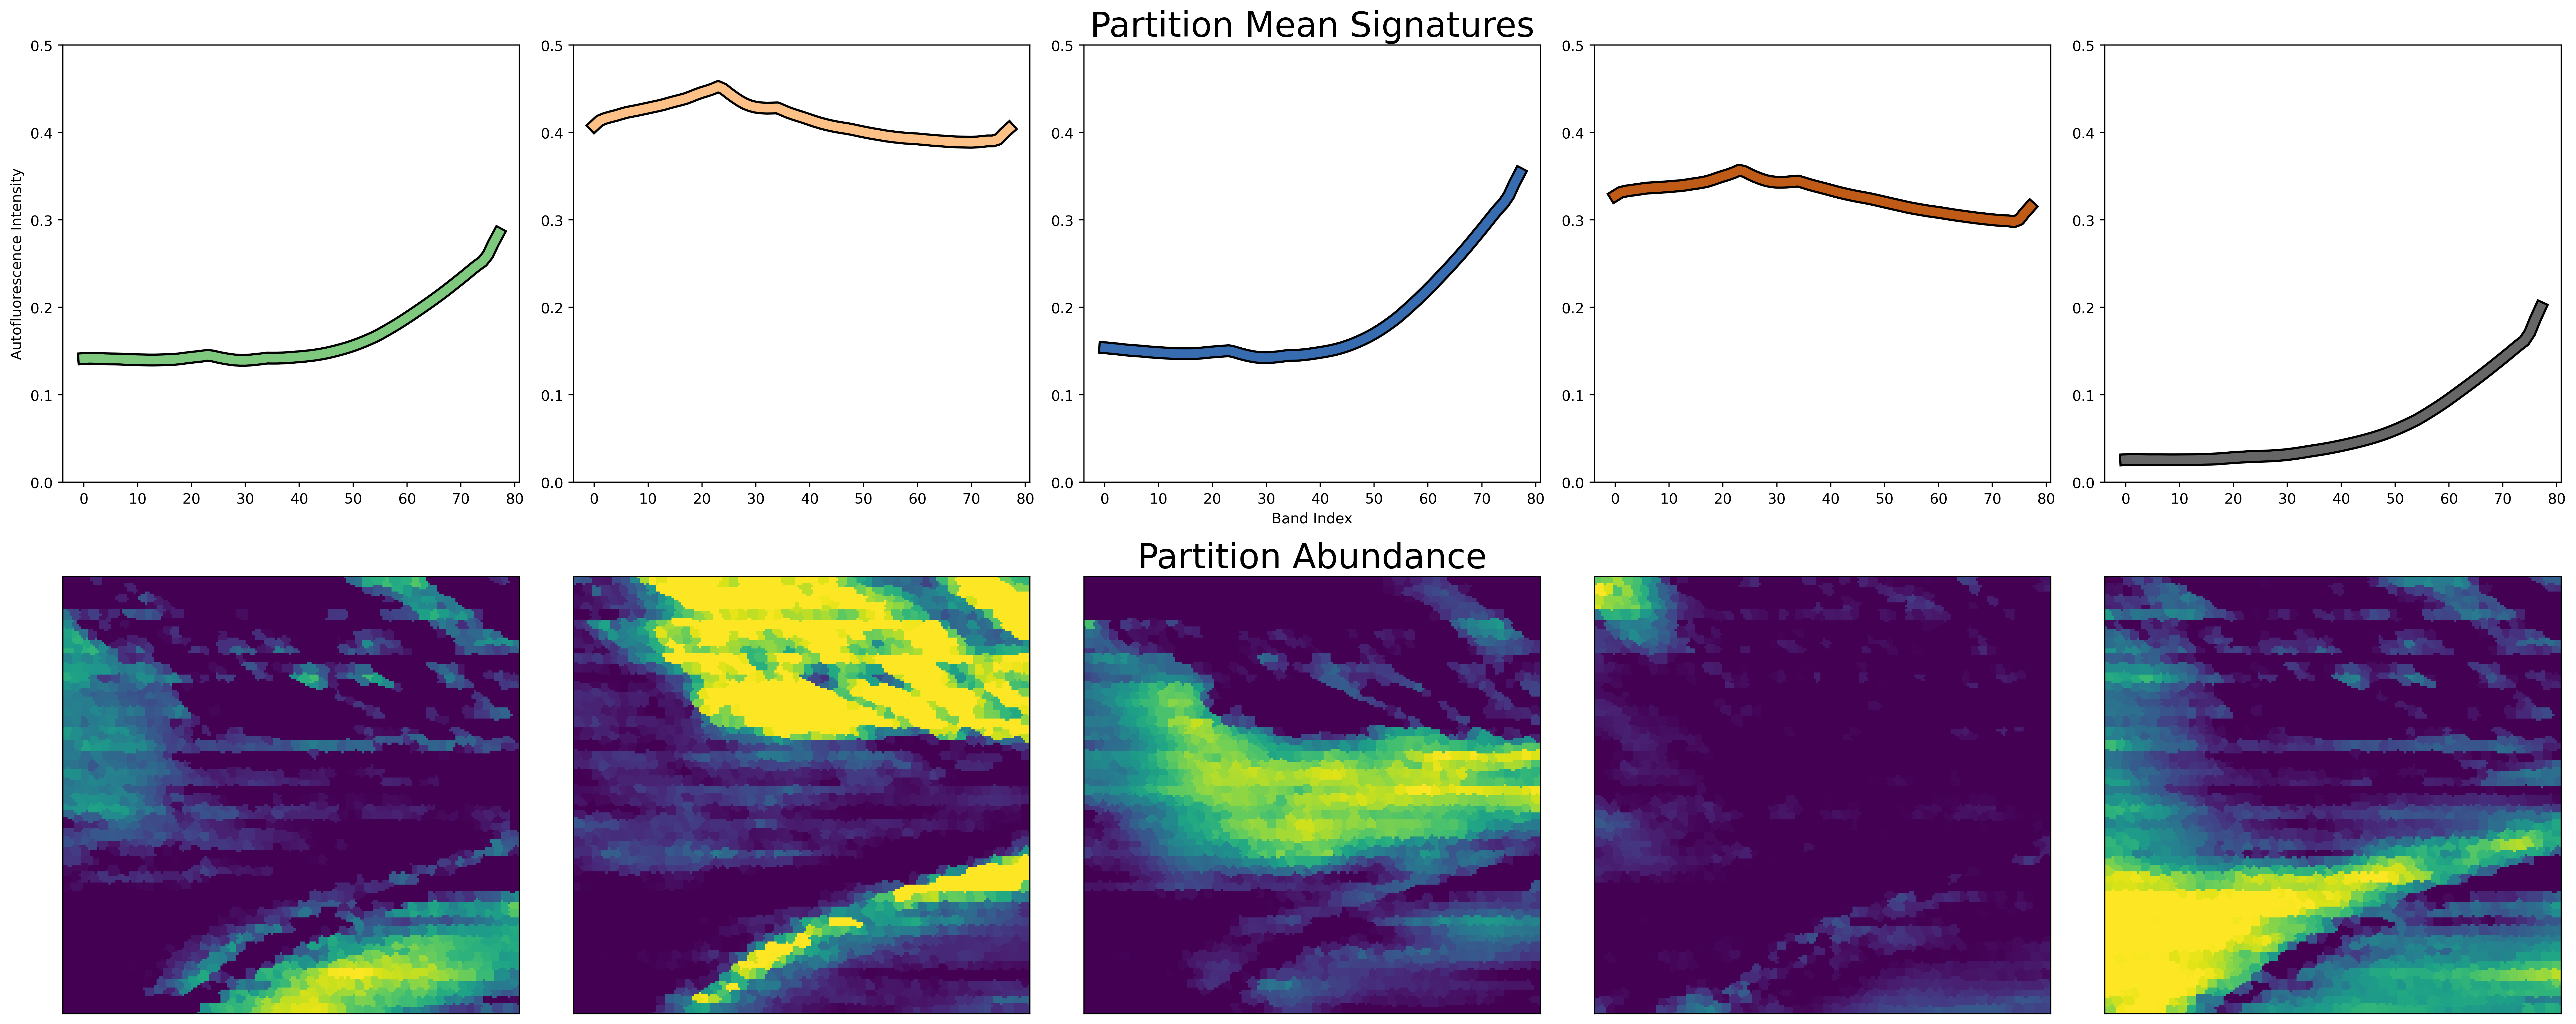

In [19]:
num_layers = min(int_results['abundance_results'].shape[2], 5)


fig, axes = plt.subplots(2, num_layers, figsize=(5*num_layers, 10), dpi = 400)

cmap = plt.cm.get_cmap('Accent');
# plt.plot(int_results['initial_spectra'][:,0], color = cmap(0), label = '1');
# plt.plot(int_results['initial_spectra'][:,1], color = cmap(0.25), label = '2');
# plt.plot(int_results['initial_spectra'][:,2], color = cmap(0.50), label = '3');
# plt.plot(int_results['initial_spectra'][:,3], color = cmap(0.75), label = '4');
# plt.plot(int_results['initial_spectra'][:,4], color = cmap(1.0), label = '5');
# plt.legend();


# Create line plots on the first row
for i in range(num_layers):
    axes[0,i].plot(int_results['initial_spectra'][:,i], color = 'black');


for i in range(num_layers):
    axes[0,i].plot(int_results['initial_spectra'][:,i], color = 'black', linewidth = 9 );
    axes[0,i].plot(int_results['initial_spectra'][:,i], color = cmap(i/4), linewidth = 6 );
    axes[1,i].imshow(int_results['abundance_results'][:, :, i], cmap='viridis', aspect = 'auto')

    
    axes[0,i].set_ylim(0, 0.5);  
    # axes[0,i].set_title(f'Partition Mean Signature {i+1}')
    # axes[1,i].set_title(f'Parition Abundances {i+1}')
    axes[1,i].set_xticks([]);
    axes[1,i].set_yticks([]);
    # axes[0,i].set_xticks([]);
    # axes[0,i].set_yticks([]);


axes[0,2].set_title(f'Partition Mean Signatures', fontsize = 24);
axes[1,2].set_title(f'Partition Abundance', fontsize = 24);

axes[0,0].set_ylabel('Autofluorescence Intensity');
axes[0,2].set_xlabel('Band Index');





# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # Create a colorbar on the right side of the figure
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
# sm.set_array([])  # This is needed to generate the colormap image for the colorbar
# cax = make_axes_locatable(axes[-1]).append_axes('right', size="2%", pad=0.1)
# fig.colorbar(sm, cax=cax, label='Colorbar Label')  # Use the created cax for colorbar placement
plt.tight_layout();

In [ ]:
_, original_superpixel_library = superpixel.generate_SLIC_superpixels(data = original_hyperspectral_cube,
                                                                      assignments = assignments)

In [ ]:
fig, axes = plt.subplots(1, 2)

In [ ]:
n_p_s = 100
fig, ax = plt.subplots(1, 2, figsize = (15,5))
sampled_pixel_indices = np.random.choice(original_superpixel_library.shape[1], size=n_p_s, replace=False)
ax[0].plot(original_superpixel_library[:,sampled_pixel_indices], alpha = 0.5);
ax[1].plot(superpixel_library[:,sampled_pixel_indices], alpha = 0.5);

ax[0].set_xlabel('Spectral Band Index');
ax[1].set_xlabel('Spectral Band Index');

ax[0].set_ylabel('Autofluoresence Intensity');
ax[1].set_ylabel('Normalized Autofluoresence Intensity');

ax[0].set_title('Observed Pixel Spectra');
ax[1].set_title('Normalized Pixel Spectra');

# fig.suptitle(f'{n_p_s} Randomly Sampled Pixels');

In [ ]:
cmap = plt.cm.get_cmap('Accent');
plt.plot(original_library[:,0], color = cmap(0), label = 'Sclera');
plt.plot(original_library[:,1], color = cmap(0.25), label = 'Inner Retina');
plt.plot(original_library[:,2], color = cmap(0.50), label = 'Muscle');
plt.plot(original_library[:,3], color = cmap(0.75), label = 'Photoreceptor');
plt.plot(original_library[:,4], color = cmap(1.0), label = 'Choroid');
plt.legend();
plt.xlabel('Spectral Band');
plt.ylabel('Autofluoresence Intensity');

In [ ]:
n_p_s = 500
plt.plot(superpixel_library[:,np.random.choice(original_superpixel_library.shape[1], size=100, replace=False)], alpha = 0.5);
plt.xlabel('Spectral Band');
plt.ylabel('Autofluoresence Intensity');
plt.title(f'{n_p_s} Randomly Sampled Pixels');

In [ ]:
cmap = plt.cm.get_cmap('Accent');
plt.plot(normalized_signatures[:,0], color = cmap(0), label = 'Sclera');
plt.plot(normalized_signatures[:,1], color = cmap(0.25), label = 'Inner Retina');
plt.plot(normalized_signatures[:,2], color = cmap(0.50), label = 'Muscle');
plt.plot(normalized_signatures[:,3], color = cmap(0.75), label = 'Photoreceptor');
plt.plot(normalized_signatures[:,4], color = cmap(1.0), label = 'Choroid');
plt.legend();
plt.xlabel('Spectral Band');
plt.ylabel('Autofluoresence Intensity');

In [ ]:
cmap = plt.cm.get_cmap('Accent');
plt.plot(original_library[:,0], color = cmap(0), label = 'Sclera');
plt.plot(original_library[:,1], color = cmap(0.25), label = 'Inner Retina');
plt.plot(original_library[:,2], color = cmap(0.50), label = 'Muscle');
plt.plot(original_library[:,3], color = cmap(0.75), label = 'Photoreceptor');
plt.plot(original_library[:,4], color = cmap(1.0), label = 'Choroid');
plt.legend();
plt.xlabel('Spectral Band');
plt.ylabel('Autofluoresence Intensity');

In [ ]:
#dict_keys(['loss', 'primal_residual', 'dual_residual', 'mean_abund_value', 'n_iters'])
view = 'dual_residual'
plt.axhline(y=1, color='r', linestyle='--');
plt.plot(int_results['unmixing_history'][view]);
plt.title(view);

In [ ]:
dataset_name = 'bhsi_1'
file_end = 'png' #.svg
savefigs = True
if savefigs:
    print("Saving Original Image")
    utility.save_hcube(hyperspectral_cube = original_hyperspectral_cube,
                       n_layers = 40,
                       output_img=f'display_imgs/{dataset_name}_original.{file_end}');

    print("Saving Preprocessed Results")
    utility.save_hcube(hyperspectral_cube = hyperspectral_cube,
                   n_layers = 40,
                   output_img=f'display_imgs/{dataset_name}_preprocessed.{file_end}');

    print("Saving Superpixel Results")
    utility.save_hcube(hyperspectral_cube = superpixeled_cube,
                   n_layers = 40,
                   output_img=f'display_imgs/{dataset_name}_superpixeled.{file_end}');

    print("Saving Abundance Results")
    utility.save_hcube(hyperspectral_cube = int_results['abundance_results'],
                   n_layers = ne,
                   output_img=f'display_imgs/{dataset_name}_abundances.{file_end}');

    print("Saving Abundance + Superpixel Results")
    step_size = 4
    utility.save_hcube(hyperspectral_cube = np.concatenate([superpixeled_cube[:,:,np.arange(0, nb, step_size)],
                                                            int_results['abundance_results']], axis = 2),
                      n_layers = np.arange(0, nb, step_size).shape[0] + ne,
                      output_img=f'display_imgs/{dataset_name}_superpixel_plus_abudance.{file_end}');

    print("Saving Segmentation Results")
    utility.save_img(image = int_results['initial_labels'],
                     output_img= f'display_imgs/{dataset_name}_initial_segmentation.{file_end}')

    utility.save_img(image = labelled_img,
                     output_img= f'display_imgs/{dataset_name}_final_segmentation.{file_end}')
    
    fig, ax = plt.subplots(ne,2, figsize = (ne+2,2*ne), dpi=150);
    for k in range(ne):
        ax[k,0].set_title(f'Initial Segment {k+1}', fontsize = 6)
        ax[k,0].imshow(int_results['initial_labels'] == k, cmap = 'gray');
        ax[k,0].set_xticks([]);
        ax[k,0].set_yticks([]);
        ax[k,1].set_title(f'Segment {k+1} Normalized Signature', fontsize = 6);
        ax[k,1].plot(int_results['initial_spectra'][:,k]);
        ax[k,1].set_ylim(0,1);  
    fig.text(0.7, 0, 'Band Index', fontsize = 8, ha='center')
    fig.text(1, 0.5, 'Reflectance Intensity', fontsize = 8, va='center', rotation='vertical')
    plt.tight_layout();
    fig.patch.set_alpha(0);
    plt.savefig(f'display_imgs/{dataset_name}_initial_segmentation_signatures.{file_end}', bbox_inches='tight');
    plt.close();
    